# Simulation of Opti-Acoustic 3D Reconstruction

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from scipy.spatial.transform import Rotation

In [2]:
def box3d(n=16):
    """Generate 3D points inside a cube with n-points along each edge"""
    points = []
    N = tuple(np.linspace(-1, 1, n))
    for i, j in [(-1, -1), (-1, 1), (1, 1), (0, 0)]:
        points.extend(set(it.permutations([(i,) * n, (j,) * n, N])))
    return np.hstack(points) / 2


def Pi(ph: np.ndarray):
    """
    Converts coordinates from homogeneous to inhomogeneous.

    Args:
        ph (np.array): shape (n+1,m)

    Returns:
        p (np.array): shape (n,m)
    """
    p = ph[:-1] / ph[-1]  # divide by and remove last coordinate
    return p


def PiInv(p: np.ndarray):
    """
    Converts coordinates from inhomogeneous to homogeneous.

    Args:
        p (np.array): shape (n,m)

    Returns:
        ph (np.array): shape (n+1,m)
    """
    ph = np.vstack((p, np.ones(p.shape[1])))
    return ph


def camera_intrinsic(f: float, c: tuple[float, float], alpha=1.0, beta=0.0):
    """
    Create a camera intrinsic matrix

    Args:
        f (float): focal length
        c (tuple): 2D principal point (x,y)
        alpha (float): skew
        beta (float): aspect ratio

    Returns:
        K (np.array): intrinsic camera matrix, shape (3, 3)
    """
    K = np.array(
        [
            [f, beta * f, c[0]],
            [0, alpha * f, c[1]],
            [0, 0, 1],
        ],
    )
    return K


def project_optical(K, R, t, Q):
    """
    Project 3D points to 2D using the pinhole model,
    without distortion.

    Args:
        K: Camera intrinsics matrix
        R: Rotation matrix
        t: Translation vector
        Q: 3D points, shape (3, n)
    """
    pose = K @ np.hstack((R, t))
    Qh = PiInv(Q)  # (4, n)
    Ph = pose @ Qh  # (3, n)
    P = Pi(Ph)  # (2, n)
    return P


def project_sonar(Qs):
    """
    Project 3D points to 2D in the sonar frame.

    Args:
        Qs: 3D points in {sonar}, shape (3, n)

    Returns:
        x: 2D points in {sonar} as (r, theta), shape (2, n)
    """
    # r = np.linalg.norm(Qs, axis=0)  # np.sqrt(x^2 + y^2 + z^2)
    x = Qs[0, :]
    y = Qs[1, :]
    z = Qs[2, :]
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arctan2(x, y)  # arctan2(x, y)
    x = np.array([r, theta])  # shape (2, n)
    return x


def range_solution(s, p, K, R, t):
    """
    Closed-form range solution for range measurements.

    Args:
        s: 2D points in {sonar} as (r, theta), shape (2, n)
        p: 2D points in {camera}, shape (2, n)
        K: Camera intrinsics matrix
        R: Rotation matrix from {camera} to {sonar}
        t: Translation vector from {camera} to {sonar}

    Returns:
        z: range measurements, shape (n,)
    """
    f = K[0, 0]
    range_ = s[0, :]
    p = np.vstack((p, f * np.ones(p.shape[1])))
    z = f * ((range_ * np.linalg.norm(p[:2]) - t.T @ R @ p) / np.linalg.norm(p[:2]) ** 2)
    z = z.reshape(-1)
    return z

def azimuth_solution(s, p, K, R, t):
    """
    Closed-form azimuth solution for range measurements.

    Args:
        s: 2D points in {sonar} as (r, theta), shape (2, n)
        p: 2D points in {camera}, shape (2, n)
        K: Camera intrinsics matrix
        R: Rotation matrix from {camera} to {sonar}
        t: Translation vector from {camera} to {sonar}

    Returns:
        z: range measurements, shape (n,)
    """
    f = K[0, 0]
    r1 = R[0, :].reshape(1, 3)
    r2 = R[1, :].reshape(1, 3)
    theta = s[1, :].reshape(-1, 1)
    tx = t[0, 0]
    ty = t[1, 0]
    p = np.vstack((p, f * np.ones(p.shape[1])))
    z = np.zeros(s.shape[1])
    for i in range(s.shape[1]):
        num = f * (np.tan(theta[i]) * ty - tx)
        den = (r1 - np.tan(theta[i]) * r2) @ p[:, i]
        z[i] = (num/den).item()
    return z

def reconstruct(p, K, Zo):
    """
    Reconstruction of 3D points from Z-values.
    """
    f = K[0, 0]
    deltax, deltay = K[0, 2], K[1, 2]
    Xo = (p[0, :] - deltax) * Zo / f
    Yo = (p[1, :] - deltay) * Zo / f
    Qo_rec = np.vstack((Xo, Yo, Zo))
    return Qo_rec


def plot_3d(Q, title, limit=None, **kwargs):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(projection="3d")
    ax.scatter(Q[0, :], Q[1, :], Q[2, :], **kwargs)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_aspect("equal")
    if limit:
        ax.set_xlim(-limit, limit)
        ax.set_ylim(-limit, limit)
        ax.set_zlim(-limit, limit)
    ax.set_title(title)


def plot_2d_sonar(x, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(x[1, :], x[0, :], s=5)
    plt.title(title)
    plt.xlabel("theta (rad)")
    plt.ylabel("range (m)")


def plot_dual_pov(p, Qs_proj, K):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle("POV of camera and sonar")
    ax[0].scatter(p[0, :], p[1, :], s=5)
    ax[0].set_title("Camera frame")
    ax[0].set_xlabel("x (pixels)")
    ax[0].set_ylabel("y (pixels)")
    ax[0].set_xlim(-K[0, 0]/2 + K[0, 2], K[0, 0]/2 + K[0, 2])
    ax[0].set_ylim(-K[0, 0]/2 + K[1, 2], K[0, 0]/2 + K[1, 2])
    ax[0].set_aspect("equal")
    ax[1].scatter(Qs_proj[0, :], Qs_proj[1, :], s=5)
    ax[1].set_title("Optical view from sonar's position")
    ax[1].set_xlabel("x (pixels)")
    ax[1].set_ylabel("y (pixels)")
    # ax[1].set_xlim(-K[0, 0]/2 + K[0, 2], K[0, 0]/2 + K[0, 2])
    # ax[1].set_ylim(-K[0, 0]/2 + K[1, 2], K[0, 0]/2 + K[1, 2])
    ax[1].set_aspect("equal")


def plot_dual_projection(p, s, K):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle("Projection of camera and sonar")
    ax[0].scatter(p[0, :], p[1, :], s=5)
    ax[0].set_title("Camera frame")
    ax[0].set_xlabel("x (pixels)")
    ax[0].set_ylabel("y (pixels)")
    ax[0].set_aspect("equal")
    ax[0].set_xlim(-K[0, 0]/2 + K[0, 2], K[0, 0]/2 + K[0, 2])
    ax[0].set_ylim(-K[0, 0]/2 + K[1, 2], K[0, 0]/2 + K[1, 2])
    ax[0].set_aspect("equal")
    ax[1].scatter(s[1, :], s[0, :], s=5)
    ax[1].set_title("Sonar frame")
    ax[1].set_xlabel("theta (rad)")
    ax[1].set_ylabel("range (m)")

In [3]:
# World config
d_baseline = 0.1  # baseline dist between {camera} and {sonar}
d_plane = 10.0 # plane dist

Qw = box3d(n=16)  # 3D points centered around origin of {world}

# Parallel camera configuration
t = np.array([[d_baseline, 0, 0]]).T
R = np.array([[1, 0, 0], 
                [0, 0, 1], 
                [0, -1, 0]])  # 90 degree rotation around x-axis

# Camera extrinsics, {world} to {camera}
tc_x = 0.0
tc_y = -0.5
tc = np.array([[tc_x, tc_y, d_plane]]).T
Rc = np.eye(3)
# theta_x = -15.0  # degrees (pitch down)
# Rc = Rotation.from_euler("xyz", [theta_x / 180.0, 0, 0]).as_matrix()
Qo = Rc @ Qw + tc  # points in {camera}

# Camera intrinsics
f = 800
deltax, deltay = (0,0)
K = camera_intrinsic(f, (deltax, deltay))

# Sonar extrinsics, {camera} to {sonar}
Qs = R @ Qo + t
# Rs = R @ Rc
# ts = R @ t + tc
# Qs_proj = project_optical(K, Rs, ts, Qs)

# Projection
p = project_optical(K, Rc, tc, Qw)
s = project_sonar(Qs)

# Reconstruction
Zo_range = range_solution(s, p, K, R, t)
Zo_azi = azimuth_solution(s, p, K, R, t)
Zo_both = np.vstack((Zo_range, Zo_azi))

Qo_rec_range = reconstruct(p, K, Zo_range)
Qo_rec_azi = reconstruct(p, K, Zo_azi)

Zo_both: 
 [range_solution azimuth_solution] [[ 8.08901859  9.5       ]
 [ 8.08635432  9.5       ]
 [ 8.08408279  9.5       ]
 [ 8.08220425  9.5       ]
 [ 8.08071891  9.5       ]
 [ 8.0796269   9.5       ]
 [ 8.07892832  9.5       ]
 [ 8.07862319  9.5       ]
 [ 8.07871148  9.5       ]
 [ 8.07919312  9.5       ]
 [ 8.08006794  9.5       ]
 [ 8.08133576  9.5       ]
 [ 8.08299632  9.5       ]
 [ 8.08504929  9.5       ]
 [ 8.08749432  9.5       ]
 [ 8.09033096  9.5       ]
 [ 8.08901859  9.5       ]
 [ 8.08331644  9.5       ]
 [ 8.07800392  9.5       ]
 [ 8.0730818   9.5       ]
 [ 8.0685508   9.5       ]
 [ 8.06441158  9.5       ]
 [ 8.06066473  9.5       ]
 [ 8.05731081  9.5       ]
 [ 8.05435031  9.5       ]
 [ 8.05178366  9.5       ]
 [ 8.04961125  9.5       ]
 [ 8.04783338  9.5       ]
 [ 8.04645032  9.5       ]
 [ 8.04546227  9.5       ]
 [ 8.04486939  9.5       ]
 [ 8.04467175  9.5       ]
 [ 8.08901859  9.5       ]
 [ 8.14501345  9.56666667]
 [ 8.20101356  9.63333333]
 [ 8.25701

In [18]:

def form_alpha(p, R):
    x, y = p[0, :], p[1, :]
    r1, r2, r3 = R[:, 0], R[:, 1], R[:, 2]
    ax = [xi * r3 - r1 for xi in x]
    ay = [yi * r3 - r2 for yi in y]
    ax = np.array(ax)
    ay = np.array(ay)
    return ax, ay


def m_solution(s, p, K, R, t):
    ax, ay = form_alpha(p, R)   # shape (n, 3), (n ,3)
    theta = s[1, :]  # shape (n,)
    z = np.zeros(s.shape[1])
    for i in range(s.shape[1]):
        ax1, ax2, ax3 = ax[i]
        ay1, ay2, ay3 = ay[i]
        th = theta[i]
        num = ((ay1 * np.tan(th) + ay2) * ax[i] - (ax1 * np.tan(th) + ax2) * ay[i]) @ t
        den = (ay1 * np.tan(th) + ay2) * ax3 - (ax1 * np.tan(th) + ax2) * ay3
        z[i] = (num/den).item()
    return z
    
z = m_solution(s, p, K, R, t)
print(z.shape)

(240,)


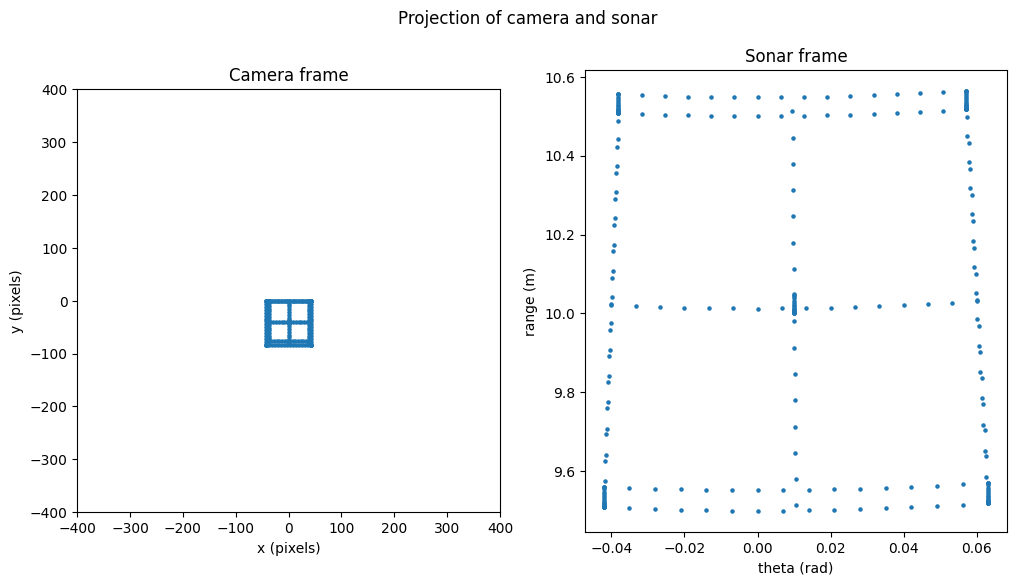

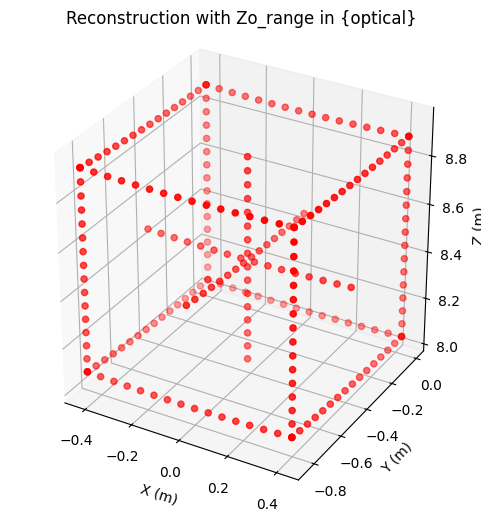

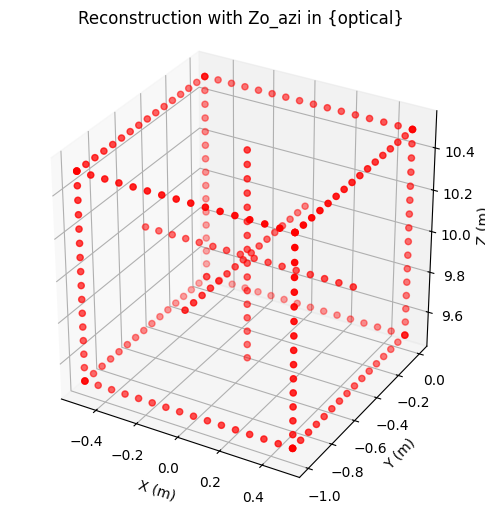

In [ ]:
# Plot
# plot_3d(Qw, "3D points in {world}")
# plot_3d(Qs, "3D points in {sonar}")
# plot_dual_pov(p, Qs_proj, K)
plot_dual_projection(p, s, K)
plot_3d(Qo_rec_range, "Reconstruction with Zo_range in {optical}", c="r")
plot_3d(Qo_rec_azi, "Reconstruction with Zo_azi in {optical}", c="r")
plt.show()